Author: Thibeau Wouters

# Physical Modelling of Complex Systems - Assignment 9

##### Import packages:

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

import cmath

In [2]:
plt.style.use('ggplot')
plt.rcParams.update(
    {"text.usetex": True,
     'font.serif': 'Modern Roman',
     "figure.figsize": (8, 4),
    "axes.titlesize" : 26,
    "axes.labelsize" : 28,
    "lines.linewidth": 3,
     "legend.fontsize":24,
    "lines.markersize" : 10,
     "legend.fontsize": 16,
    "xtick.labelsize" : 24,
    "ytick.labelsize" : 24})

# Brusselator model as toy model for the Belousov-Zhabotinsky reaction 

The Brusselator model is (see report for more details) $$ \begin{align}
    \frac{\partial u}{\partial t} &= \gamma(a - (b+1)u + u^2v) + \frac{\partial^2u}{\partial x^2} \\
    \frac{\partial v}{\partial t} &= \gamma(b u - u^2v) + d \frac{\partial^2 v}{\partial x^2} \, .
\end{align} $$

## 9.1 - Homogeneous steady state solutions

Save the default values.

In [3]:
d = 22.4/2.8; a = 1.5

The homogeneous steady state solutions are $$ (u_0, v_0) = \left( a, \frac{b}{a} \right) $$

## 9.2 - Growth rates etc

In [4]:
def h(ksq, b, gamma = 1, a = 1.5, d = 22.4/2.8):
    '''The function h(k^2)'''
    
    return d*ksq**2 - gamma*(d*(b - 1) - a**2)*ksq + gamma**2*a**2

In [5]:
def b_critical(d = 22.4/2.8, a = 1.5):
    '''Compute the critical value for b'''
    
    return (np.sqrt(d) + a)**2/d

In [6]:
def kmsq(b, gamma = 1, d = 22.4/2.8):
    '''Compute k_m^2 for given b'''
    
    return gamma*(d*(b - 1) - a**2)/(2*d)

Save the critical value of $b$ for default parameters used in the exercise

In [7]:
bc = b_critical()
print('The critical value for b is', bc)

The critical value for b is 2.341910171779821


The two constraints:

In [8]:
b_upper_bound = 1 + a**2; b_lower_bound = 1 + a**2/d
print('b has to lie between %0.5f and %0.2f' % (b_lower_bound, b_upper_bound))

b has to lie between 1.28125 and 3.25


### 9.2.1 - $h(k^2)$ for varying values of $b$

Now plot the parabola:

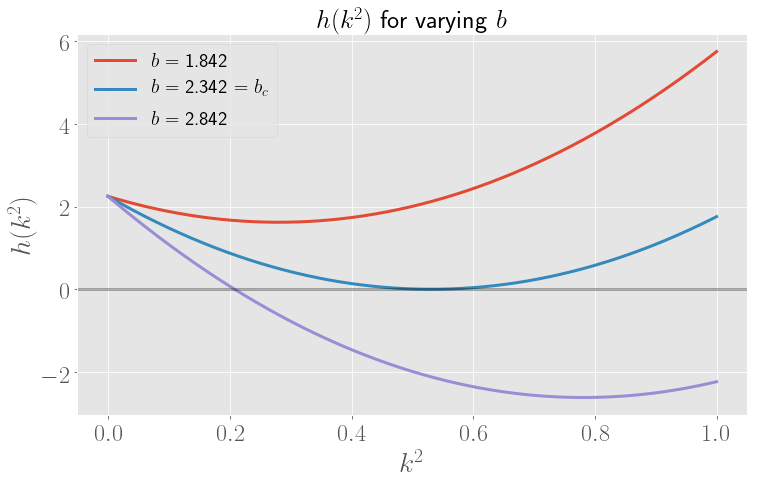

In [10]:
plt.figure(figsize = (12, 7))

# b values we want to plot
b_vals = [bc - 0.5, bc, bc + 0.5]
for b in b_vals:
    ksq_vals = np.arange(0, 1, 0.001)
    h_vals = h(ksq_vals, b)
    km = kmsq(b)
    
    if b == bc:
        plt.plot(ksq_vals, h_vals, label = '$b = $ % 0.3f $ = b_c$' % b)
    else:
        plt.plot(ksq_vals, h_vals, label = '$b = $ % 0.3f' % b)
    
    #plt.scatter(km, h(km, b), color = 'black', zorder = 10)

# Make fancy, save and show
plt.axhline(y = 0, color = 'black', alpha = 0.3)
plt.legend(fontsize = 20)
plt.xlabel(r'$k^2$')
plt.ylabel(r'$h(k^2)$')
plt.title(r'$h(k^2)$ for varying $b$')
plt.savefig('h_functions.pdf', bbox_inches = 'tight')
plt.show()

$ \textbf{Growth rates} $

In [11]:
def sigma_k(ksq, b, gamma = 1, a = 1.5, d = 22.4/2.8):
    '''Computes growth rates. Note: returns complex numbers!'''
    
    under_sqrt = complex((ksq*(1 + d) - gamma*(b - 1 - a**2))**2 - 4*h(ksq, b))
    sigma_k = 0.5*(gamma*(b - 1 - a**2) - ksq*(1 + d) + cmath.sqrt(under_sqrt))
    
    # sigma_k is now a complex number
    return sigma_k

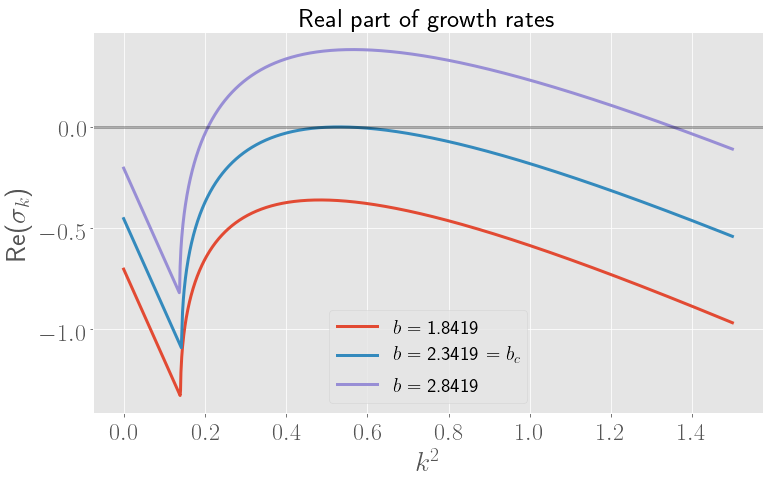

In [12]:
plt.figure(figsize = (12, 7))

ksq_vals = np.arange(0, 1.5, 0.001)

# Need to use a for loop, since we have to take the real part each time

b_vals = [bc - 0.5, bc, bc + 0.5]
for b in b_vals:

    sigma_k_vals = []
    for ksq in ksq_vals:
        sigma_k_vals.append(sigma_k(ksq, b).real)
    
    if b == bc:
        plt.plot(ksq_vals, sigma_k_vals, label = r'$b = $ %0.4f $ = b_c$' % b)
    else:
        plt.plot(ksq_vals, sigma_k_vals, label = r'$b = $ %0.4f' % b)

# Make fancy, save and show
plt.axhline(y = 0, color = 'black', alpha = 0.3)
plt.xlabel(r'$k^2$')
plt.ylabel(r'Re($\sigma_k$)')
plt.title('Real part of growth rates')
plt.legend(fontsize = 20)
plt.savefig('growth_rates.pdf', bbox_inches = 'tight')
plt.show()

## 9.3 - Spatiotemporal behaviour

We first define/repeat a bunch of functions which will allow us to solve the PDE of the Brusselator model.

#### Setting up the PDE solver

In [13]:
def get_x_values(a, b, N):
    '''Gives the x-values and separation in the partition, of length N, of the interval a, b'''
    
    x_vals= np.linspace(a, b, N)
    DeltaX = abs(x_vals[1] - x_vals[0])
    
    return x_vals, DeltaX

The reaction functions for this model.

In [14]:
def reaction_func_u(u, v, b, a = 1.5):
    
    return a - (b+1)*u + u**2*v

In [15]:
def reaction_func_v(u, v, b):
    
    return b*u - u**2*v

To compute the right hand sides:

In [16]:
def u_0_dot(g, u0, u1, v0, b, DeltaX, reaction_func = reaction_func_u, reaction = 1):

    return ((1/DeltaX)**2)*(u1 - u0) + g*reaction*reaction_func(u0, v0, b)

In [17]:
def v_0_dot(g, v0, v1, u0, b, DeltaX, d = 22.4/2.8, reaction_func = reaction_func_v, reaction = 1):
    
    return d*((1/DeltaX)**2)*(v1 - v0) + g*reaction*reaction_func(u0, v0, b)

In [18]:
def u_n_dot(g, unm1, un, unp1, vn, b, DeltaX, reaction_func = reaction_func_u, reaction = 1):
    
    return ((1/DeltaX)**2)*(unp1 - 2*un + unm1) + g*reaction*reaction_func(un, vn, b)

In [19]:
def v_n_dot(g, vnm1, vn, vnp1, un, b, DeltaX, d = 22.4/2.8, reaction_func = reaction_func_v, reaction = 1):
    
    return d*((1/DeltaX)**2)*(vnp1 - 2*vn + vnm1) + g*reaction*reaction_func(un, vn, b)

In [20]:
def u_Nm1_dot(g, uNm2, uNm1, vNm1, b, DeltaX, reaction_func = reaction_func_u, reaction = 1):
    
    return ((1/DeltaX)**2)*(uNm2 - uNm1) + g*reaction*reaction_func(uNm1, vNm1, b)

In [21]:
def v_Nm1_dot(g, vNm2, vNm1, uNm1, b, DeltaX, d = 22.4/2.8, reaction_func = reaction_func_v, reaction = 1):
    
    return d*((1/DeltaX)**2)*(vNm2 - vNm1) + g*reaction*reaction_func(uNm1, vNm1, b)

Solver for a system of two PDE's:

In [22]:
def solve_PDE_2D(left_bound, right_bound, N, in_conds_list, t_vals, b, reaction_func_list = [reaction_func_u, reaction_func_v], Du = 2.8, Dv = 22.4, reaction = 1):
    '''Solves a reaction-diffusion PDE, like the Fisher-Kolmogorov equation'''
        
    L = abs(right_bound - left_bound)
    gamma = L**2/Du
    d = Dv/Du
    
    # Get x values and Delta X separation (same for both u and v)
    x_vals, DeltaX = get_x_values(left_bound, right_bound, N)
    
    # Return values: dictionary with at each x_n point, the list of u_n points, for all times integrated
    return_values_u = {}; return_values_v = {}
    
    # Last values:  when a new value at x_n is computed, store it for the next calculation (faster computations)
    last_values_u = {}; last_values_v = {}
    
    # Get reaction functions
    reaction_func_u, reaction_func_v = reaction_func_list[0], reaction_func_list[1]
    
    # Get the initial conditions (list of two lists) NOTE: values should already be computed!
    initial_u, initial_v = in_conds_list[0], in_conds_list[1]
    for i in range(N):
        return_values_u[i] = [initial_u[i]]
        last_values_u[i]= initial_u[i]
        
        return_values_v[i] = [initial_v[i]]
        last_values_v[i] = initial_v[i]
    
    # Get the value of Delta t for calculations (same for both u and v)
    DeltaT = abs(t_vals[1] - t_vals[0])
    
    # Compute all the other values at all other times
    for t in t_vals:
        if t == t_vals[0]:
            
            # Initial condition: already added, so do nothing in this step
            pass
            
        else:
            for i in range(N):
                if i == 0:
                    
                    new_u0_value = last_values_u[i] + u_0_dot(gamma, last_values_u[i], last_values_u[i + 1], last_values_v[i], b, DeltaX, reaction_func_u, reaction)*DeltaT
                    return_values_u[i].append(new_u0_value)
                    last_values_u[i] = new_u0_value
                    
                    new_v0_value = last_values_v[i] + v_0_dot(gamma, last_values_v[i], last_values_v[i + 1], last_values_u[i], b, DeltaX, d,  reaction_func_v, reaction)*DeltaT
                    return_values_v[i].append(new_v0_value)
                    last_values_v[i] = new_v0_value
                    
                elif i == N - 1:
                    
                    new_uNm1_value = last_values_u[i] + u_Nm1_dot(gamma, last_values_u[i - 1], last_values_u[i], last_values_v[i], b, DeltaX, reaction_func_u, reaction)*DeltaT
                    return_values_u[i].append(new_uNm1_value)
                    last_values_u[i] = new_uNm1_value
                    
                    new_vNm1_value = last_values_v[i] + v_Nm1_dot(gamma, last_values_v[i - 1], last_values_v[i], last_values_u[i], b, DeltaX, d, reaction_func_v, reaction)*DeltaT
                    return_values_v[i].append(new_vNm1_value)
                    last_values_v[i] = new_vNm1_value
                    
                else: # 1 <= i <= N-2
                    
                    new_un_value = last_values_u[i] + u_n_dot(gamma, last_values_u[i - 1], last_values_u[i], last_values_u[i+1], last_values_v[i], b, DeltaX, reaction_func_u, reaction)*DeltaT
                    return_values_u[i].append(new_un_value)
                    last_values_u[i] = new_un_value
                    
                    new_vn_value = last_values_v[i] + v_n_dot(gamma, last_values_v[i - 1], last_values_v[i], last_values_v[i+1], last_values_u[i], b, DeltaX, d, reaction_func_v, reaction)*DeltaT
                    return_values_v[i].append(new_vn_value)
                    last_values_v[i] = new_vn_value
            
    return return_values_u, return_values_v, x_vals

In [23]:
def get_y_values(values, x_vals, index = -1):
    '''Get the numerical values at a certain index (time). Default is last computed value.'''
    
    # Get the final value for each x point
    y_vals = []
    for i in range(len(x_vals)):
        y_vals.append(values[i][index])
    
    return y_vals

$ \textbf{Note:} $ Most code blocks are in comment, since the calculations take some time.

---

#### Numerical exploration of the dynamics

Below, we will restrict ourselves to a finite domain size of the form $x \in [0, L]$ with zero flux boundary conditions.

First sort of perturbation: small sine wave on top of HSS.

In [24]:
def u_in_sine(x, L, n =1, A = 0.1, a = 1.5):
    '''Perturbation is small sine on top of HSS'''
    return a + A*np.cos((n*np.pi*x)/(L))

In [25]:
def v_in_sine(x, L, b, n =1, A = 0.1, a = 1.5):
    '''Perturbation is small sine on top of HSS'''
    return b/a + A*np.cos((n*np.pi*x)/(L))

Second sort of perturbation: white noise (inspired by: https://stackoverflow.com/questions/32237769/defining-a-white-noise-process-in-python).

In [26]:
def u_in_WN(x, A = 0.1, a = 1.5):
    '''Perturbation is white noise on top of HSS'''
    num_samples = len(x)
    WN_samples = np.random.normal(0, A, size = num_samples)
    HSS = np.array([a for i in x])
    
    return HSS + WN_samples

In [27]:
def v_in_WN(x, b, A = 0.1, a = 1.5):
    '''Perturbation is white noise on top of HSS'''
    num_samples = len(x)
    WN_samples = np.random.normal(0, A, size = num_samples)
    HSS = np.array([b/a for i in x])
    
    return HSS + WN_samples

Now the same, but with a uniform distribution.

In [28]:
def u_in_WN_uniform(x, A = 0.1, a = 1.5):
    '''Perturbation is white noise on top of HSS'''
    num_samples = len(x)
    WN_samples = np.random.uniform(-A, A, size = num_samples)
    HSS = np.array([a for i in x])
    
    return HSS + WN_samples

In [29]:
def v_in_WN_uniform(x, b, A = 0.1, a = 1.5):
    '''Perturbation is white noise on top of HSS'''
    num_samples = len(x)
    WN_samples = np.random.uniform(-A, A, size = num_samples)
    HSS = np.array([b/a for i in x])
    
    return HSS + WN_samples

#### Test of the PDE solver:

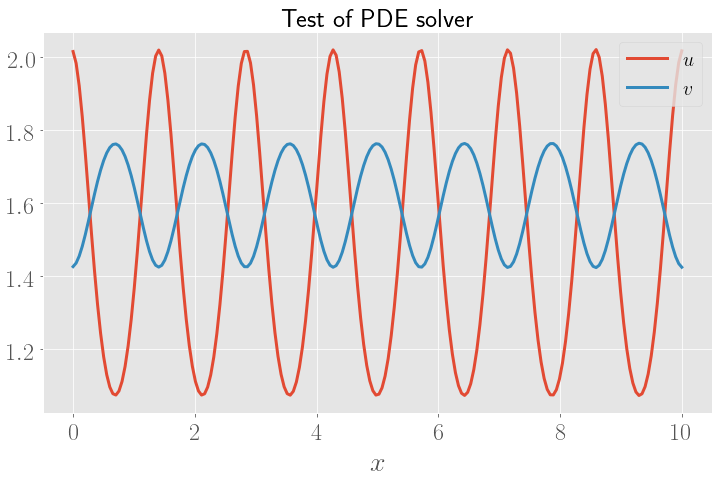

In [30]:
# Set parameters
L = 10; N = 200

b = bc + 0.1
t_vals = np.arange(0, 5, 0.0001)

# Compute initial condition
x_vals, DeltaX = get_x_values(0, L, N)
u_initial = u_in_sine(x_vals, L)
v_initial  = v_in_sine(x_vals, L, b)

# Compute all values
u_vals_dict, v_vals_dict, x_vals = solve_PDE_2D(0, L, N, [u_initial, v_initial], t_vals, b)

# Get values at last t
u_vals = get_y_values(u_vals_dict, x_vals); v_vals = get_y_values(v_vals_dict, x_vals)

# Plot
plt.figure(figsize = (12, 7))
plt.plot(x_vals, u_vals, label = r'$u$')
plt.plot(x_vals, v_vals, label = r'$v$')
plt.legend(fontsize = 20)
plt.xlabel(r'$x$')
plt.title('Test of PDE solver')
plt.savefig('test_PDE_solver.pdf', bbox_inches = 'tight')
plt.show()

The pattern has a wavelength of around 1.4 (estimated by limiting the $x$ and $u$ range or 'zooming in'). This is

In [78]:
k_c = np.sqrt(kmsq(bc + 0.1, gamma = 10**2/2.8))
k_c

4.552589866885467

In [79]:
omega_c = (2*np.pi)/k_c
omega_c

1.3801342732149207

### 9.3.1 - Varying $b$

Recall the bounds on $b$

In [31]:
print('b has to lie between %0.4f and %0.2f' % (b_lower_bound, b_upper_bound))

b has to lie between 1.2812 and 3.25


#### With sine perturbation as initial condition: 

Only $u$:

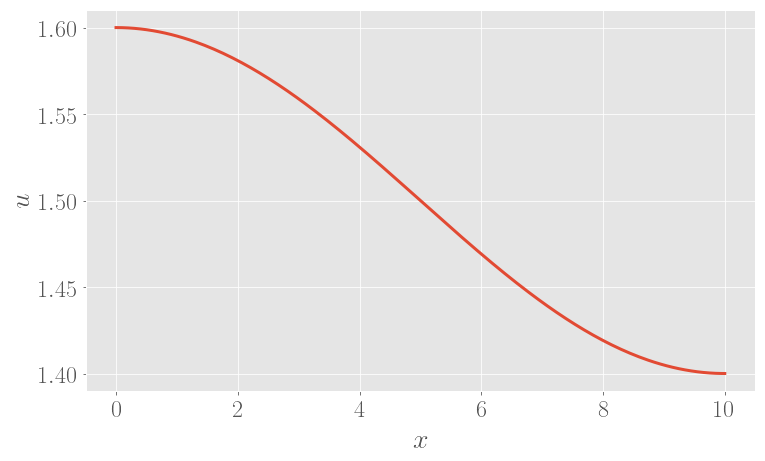

In [32]:
L = 10; N = 200
t_vals = np.arange(0, 5, 0.0001)
x_vals, DeltaX = get_x_values(0, L, N)

u_initial = u_in_sine(x_vals, L)
plt.figure(figsize = (12, 7))
plt.plot(x_vals, u_initial)
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.savefig('example_sine_IC.pdf', bbox_inches = 'tight')
plt.show()

In [33]:
# # b values we want to explore
# b_vals = np.linspace(1.5, 3, 4)

# # Other plot parameters:
# L = 10; N = 200
# t_vals = np.arange(0, 5, 0.0001)
# x_vals, DeltaX = get_x_values(0, L, N)
# title_list = ['b = %0.1f' % b for b in b_vals]

# # Plot
# u_initial = u_in_sine(x_vals, L)

# fig, axs = plt.subplots(2, 2, figsize = (30, 30))
# for i in range(len(b_vals)):
#     ax = axs[i//2, i%2]; b = b_vals[i]; title = title_list[i]
    
#     # Compute initial condition for v (depends on b)
#     v_initial  = v_in_sine(x_vals, L, b)
    
#     # Compute and get values
#     u_vals_dict, v_vals_dict, x_vals = solve_PDE_2D(0, L, N, [u_initial, v_initial], t_vals, b)
#     u_vals = get_y_values(u_vals_dict, x_vals); v_vals = get_y_values(v_vals_dict, x_vals)
    
#     ax.plot(x_vals, u_vals)
#     ax.plot(x_vals, v_vals)
    
#     ax.set_title(title, fontsize = 33)
#     ax.set_xlabel(r'$x$')
# #     ax.set_ylabel(r'$u$')

# plt.savefig('varying_b_u_and_v.pdf', bbox_inches = 'tight')
# plt.show()

With white noise as initial condition: (I did not include this in the report: nothing interesting happens)

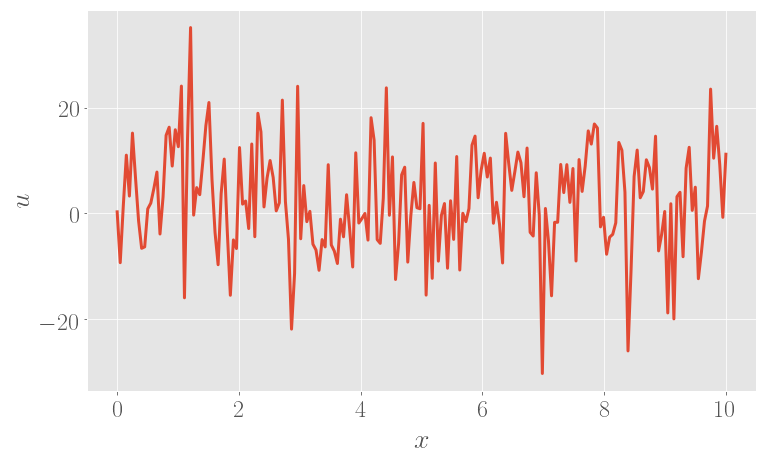

In [34]:
u_initial = u_in_WN(x_vals, L)
plt.figure(figsize = (12, 7))
plt.plot(x_vals, u_initial)
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.savefig('example_WN_IC.pdf', bbox_inches = 'tight')
plt.show()

Note: the results are almost the same as for the sine, probably because the times are quite late and the form of the perturbation does not really matter, since they both evolve towards the same end pattern.

In [35]:
# # b values we want to explore
# b_vals = np.linspace(1.5, 3, 4)

# # Other plot parameters:
# L = 10; N = 200
# t_vals = np.arange(0, 5, 0.0001)
# x_vals, DeltaX = get_x_values(0, L, N)
# title_list = ['b = %0.1f' % b for b in b_vals]

# # Plot
# u_initial = u_in_WN(x_vals)

# fig, axs = plt.subplots(2, 2, figsize = (30, 30))
# for i in range(len(b_vals)):
#     ax = axs[i//2, i%2]; b = b_vals[i]; title = title_list[i]
    
#     # Compute initial condition for v (depends on b)
#     v_initial = v_in_WN(x_vals, b)
    
#     # Compute and get values
#     u_vals_dict, v_vals_dict, x_vals = solve_PDE_2D(0, L, N, [u_initial, v_initial], t_vals, b)
#     u_vals = get_y_values(u_vals_dict, x_vals); v_vals = get_y_values(v_vals_dict, x_vals)
    
#     ax.plot(x_vals, u_vals)
#     ax.plot(x_vals, v_vals)
    
#     ax.set_title(title, fontsize = 33)
#     ax.set_xlabel(r'$x$')
# #     ax.set_ylabel(r'$u$')

# plt.savefig('varying_b_WN_u_and_v.pdf', bbox_inches = 'tight')
# plt.show()

### 9.3.2 - Varying initial condition

From now on: only plot $u$ and $v$ together, since this most clearly shows the pattern.

(1) A sine wave on top of HSS: various sine waves

In [36]:
# # n values we want to explore
# n_vals = [3, 11, 25, 50]

# # Other plot parameters:
# L = 10; N = 200
# b = bc + 0.1
# t_vals = np.arange(0, 5, 0.0001)
# x_vals, DeltaX = get_x_values(0, L, N)
# title_list = ['n = %d' % n for n in n_vals]

# # Plot
# fig, axs = plt.subplots(2, 2, figsize = (30, 30))
# for i in range(len(b_vals)):
#     ax = axs[i//2, i%2]; n = n_vals[i]; title = title_list[i]
    
#     # Compute initial conditions: depend on n!
#     u_initial = u_in_sine(x_vals, L, n = n)
#     v_initial  = v_in_sine(x_vals, L, b, n = n)
    
#     # Compute and get values
#     u_vals_dict, v_vals_dict, x_vals = solve_PDE_2D(0, L, N, [u_initial, v_initial], t_vals, b)
#     u_vals = get_y_values(u_vals_dict, x_vals); v_vals = get_y_values(v_vals_dict, x_vals)
    
#     ax.plot(x_vals, u_vals)
#     ax.plot(x_vals, v_vals)
    
#     ax.set_title(title, fontsize = 33)
#     ax.set_xlabel(r'$x$')
# #     ax.set_ylabel(r'$u$')

# plt.savefig('varying_IC_sines.pdf', bbox_inches = 'tight')
# plt.show()

White noise:

In [37]:
# # n values we want to explore
# A_vals = [0.0001, 0.01, 1, 3]

# # Other plot parameters:
# L = 10; N = 200
# b = bc + 0.1
# t_vals = np.arange(0, 5, 0.0001)
# x_vals, DeltaX = get_x_values(0, L, N)
# title_list = ['A = %0.4f' % A for A in A_vals]

# # Plot
# fig, axs = plt.subplots(2, 2, figsize = (30, 30))
# for i in range(len(b_vals)):
#     ax = axs[i//2, i%2]; A = A_vals[i]; title = title_list[i]
    
#     # Compute initial conditions: depend on n!
#     u_initial = u_in_WN(x_vals, A = A)
#     v_initial  = v_in_WN(x_vals, b, A = A)
    
#     # Compute and get values
#     u_vals_dict, v_vals_dict, x_vals = solve_PDE_2D(0, L, N, [u_initial, v_initial], t_vals, b)
#     u_vals = get_y_values(u_vals_dict, x_vals); v_vals = get_y_values(v_vals_dict, x_vals)
    
#     ax.plot(x_vals, u_vals)
#     ax.plot(x_vals, v_vals)
    
#     ax.set_title(title, fontsize = 33)
#     ax.set_xlabel(r'$x$')
# #     ax.set_ylabel(r'$u$')

# plt.savefig('varying_IC_WN.pdf', bbox_inches = 'tight')
# plt.show()

White noise, but with uniform distribution (not included in the report, nothing interesting happens):

In [38]:
# # n values we want to explore
# A_vals = [0.0001, 0.01, 1, 3]

# # Other plot parameters:
# L = 10; N = 200
# b = bc + 0.1
# t_vals = np.arange(0, 5, 0.0001)
# x_vals, DeltaX = get_x_values(0, L, N)
# title_list = ['A = %0.4f' % A for A in A_vals]

# # Plot
# fig, axs = plt.subplots(2, 2, figsize = (30, 30))
# for i in range(len(b_vals)):
#     ax = axs[i//2, i%2]; A = A_vals[i]; title = title_list[i]
    
#     # Compute initial conditions: depend on n!
#     u_initial = u_in_WN_uniform(x_vals, A = A)
#     v_initial  = v_in_WN_uniform(x_vals, b, A = A)
    
#     # Compute and get values
#     u_vals_dict, v_vals_dict, x_vals = solve_PDE_2D(0, L, N, [u_initial, v_initial], t_vals, b)
#     u_vals = get_y_values(u_vals_dict, x_vals); v_vals = get_y_values(v_vals_dict, x_vals)
    
#     ax.plot(x_vals, u_vals)
#     ax.plot(x_vals, v_vals)
    
#     ax.set_title(title, fontsize = 33)
#     ax.set_xlabel(r'$x$')
# #     ax.set_ylabel(r'$u$')

# plt.savefig('varying_IC_WN2.pdf', bbox_inches = 'tight')
# plt.show()

### 9.3.3 - Varying domain size

In [39]:
# # n values we want to explore
# L_vals = [10, 15, 20, 50]

# # Other plot parameters:
# N = 200
# b = bc + 0.1
# t_vals = np.arange(0, 5, 0.0001)
# title_list = ['L = %d' % L for L in L_vals]

# # Plot
# fig, axs = plt.subplots(2, 2, figsize = (30, 30))
# for i in range(len(L_vals)):
#     ax = axs[i//2, i%2]; L = L_vals[i]; title = title_list[i]
    
#     if L == 50: # better partition for last value of N
#         N = 400
    
#     x_vals, DeltaX = get_x_values(0, L, N)
    
#     # Compute initial conditions: depend on L!
#     u_initial = u_in_sine(x_vals, L)
#     v_initial  = v_in_sine(x_vals, L, b)
    
#     # Compute and get values
#     u_vals_dict, v_vals_dict, x_vals = solve_PDE_2D(0, L, N, [u_initial, v_initial], t_vals, b)
#     u_vals = get_y_values(u_vals_dict, x_vals); v_vals = get_y_values(v_vals_dict, x_vals)
    
#     ax.plot(x_vals, u_vals)
#     ax.plot(x_vals, v_vals)
    
#     ax.set_title(title, fontsize = 33)
#     ax.set_xlabel(r'$x$')
# #     ax.set_ylabel(r'$u$')

# plt.savefig('varying_DS_sines.pdf', bbox_inches = 'tight')
# plt.show()

Look closer at the plot for $L = 20$: integrate until $t = 10$. Observation: the same pattern with the 'deeper sub-structure' persists, and no further convergence is observed.

In [40]:
# # Set parameters
# L = 20; N = 200

# b = bc + 0.1
# t_vals = np.arange(0, 10, 0.0001)

# # Compute initial condition
# x_vals, DeltaX = get_x_values(0, L, N)
# u_initial = u_in_sine(x_vals, L)
# v_initial  = v_in_sine(x_vals, L, b)

# # Compute all values
# u_vals_dict, v_vals_dict, x_vals = solve_PDE_2D(0, L, N, [u_initial, v_initial], t_vals, b)

# # Get values at last t
# u_vals = get_y_values(u_vals_dict, x_vals); v_vals = get_y_values(v_vals_dict, x_vals)

# # Plot
# plt.figure(figsize = (12, 7))
# plt.plot(x_vals, u_vals)
# plt.plot(x_vals, v_vals)
# plt.xlabel(r'$x$')
# plt.title(r'$L = 20$, $t = 10$')
# plt.savefig('L_20_high_t.pdf', bbox_inches = 'tight')
# plt.show()

Now look closer at the plot for $L = 50$. Is there really no pattern formation? No! Even if we increase time to $t = 10$, there is no indication of pattern formation at all (plot not included in the report).

In [41]:
# # Set parameters
# L = 50; N = 400

# b = bc + 0.1
# t_vals = np.arange(0, 10, 0.0001)

# # Compute initial condition
# x_vals, DeltaX = get_x_values(0, L, N)
# u_initial = u_in_sine(x_vals, L)
# v_initial  = v_in_sine(x_vals, L, b)

# # Compute all values
# u_vals_dict, v_vals_dict, x_vals = solve_PDE_2D(0, L, N, [u_initial, v_initial], t_vals, b)

# # Get values at last t
# u_vals = get_y_values(u_vals_dict, x_vals); v_vals = get_y_values(v_vals_dict, x_vals)

# # Plot
# plt.figure(figsize = (12, 7))
# plt.plot(x_vals, u_vals)
# plt.plot(x_vals, v_vals)
# plt.xlabel(r'$x$')
# plt.title(r'$L = 50$, $t = 10$')
# plt.savefig('L_50_late_time.pdf', bbox_inches = 'tight')
# plt.show()

Also want to investigate: at $t = 5$ but what if we increase $n$ from the perturbation? Turns out: nothing happens!

In [42]:
# # Set parameters
# L = 50; N = 400

# b = bc + 0.1
# t_vals = np.arange(0, 5, 0.0001)

# # Compute initial condition
# n = 350
# x_vals, DeltaX = get_x_values(0, L, N)
# u_initial = u_in_sine(x_vals, L, n = n, A = 1)
# v_initial  = v_in_sine(x_vals, L, b, n = n, A = 1)

# # Compute all values
# u_vals_dict, v_vals_dict, x_vals = solve_PDE_2D(0, L, N, [u_initial, v_initial], t_vals, b)

# # Get values at last t
# u_vals = get_y_values(u_vals_dict, x_vals); v_vals = get_y_values(v_vals_dict, x_vals)

# # Plot
# plt.figure(figsize = (12, 7))
# plt.plot(x_vals, u_vals)
# plt.plot(x_vals, v_vals)
# plt.xlabel(r'$x$')
# plt.title(r'$L = 50$, $n = $ % d' % n)
# plt.savefig('L_50_high_n.pdf', bbox_inches = 'tight')
# plt.show()

Really no pattern??? What would be the wavelength of the pattern?

In [80]:
k_c = np.sqrt(kmsq(bc + 0.1, gamma = 50**2/2.8))
k_c

22.762949334427336

In [81]:
omega_c = (2*np.pi)/k_c
omega_c

0.2760268546429841

Maybe another initial condition which has an unstable wavemode?

Look at the bounds for $k$.

In [45]:
def compute_k_bounds(n, L, b, a = 1.5, d = 8):
    c = d*(b-1) - a**2
    gamma = L**2/2.8
    
    k_m = np.sqrt(gamma/(2*d)*(c - np.sqrt(c**2 - 4*d*a**2)))
    k_p = np.sqrt(gamma/(2*d)*(c + np.sqrt(c**2 - 4*d*a**2)))
    
    print('k bounds are: km = %0.4f and kp = % 0.4f' % (k_m, k_p))
    
    our_k = n*np.pi/L
    print('Our ksq for IC is %0.4f' % our_k)
    
    return

In [46]:
compute_k_bounds(350, 50, bc + 0.1)

k bounds are: km = 17.5427 and kp =  26.9918
Our ksq for IC is 21.9911


Study other $L$ between 20 and 50:

In [43]:
# # n values we want to explore
# L_vals = [25, 30, 35, 40]

# # Other plot parameters:
# N = 200
# b = bc + 0.1
# t_vals = np.arange(0, 5, 0.0001)
# title_list = ['L = %d' % L for L in L_vals]

# # Plot
# fig, axs = plt.subplots(2, 2, figsize = (30, 30))
# for i in range(len(L_vals)):
#     ax = axs[i//2, i%2]; L = L_vals[i]; title = title_list[i]
    
#     x_vals, DeltaX = get_x_values(0, L, N)
    
#     # Compute initial conditions: depend on L!
#     u_initial = u_in_sine(x_vals, L, n = 10)
#     v_initial  = v_in_sine(x_vals, L, b, n = 10)
    
#     # Compute and get values
#     u_vals_dict, v_vals_dict, x_vals = solve_PDE_2D(0, L, N, [u_initial, v_initial], t_vals, b)
#     u_vals = get_y_values(u_vals_dict, x_vals); v_vals = get_y_values(v_vals_dict, x_vals)
    
#     ax.plot(x_vals, u_vals)
#     ax.plot(x_vals, v_vals)
    
#     ax.set_title(title, fontsize = 33)
#     ax.set_xlabel(r'$x$')
# #     ax.set_ylabel(r'$u$')

# plt.savefig('varying_DS_sines2.pdf', bbox_inches = 'tight')
# plt.show()

Now, what if we go to $L \leq 10$? We have overflow for $L = 1, 2, 5$: no patterns are formed (cf. Murray). At $L = 7$, we have a pattern, but a very 'weak' one;

In [44]:
# # n values we want to explore
# L_vals = [1, 2, 5, 7]

# # Other plot parameters:
# N = 200
# b = bc + 0.1
# t_vals = np.arange(0, 5, 0.0001)
# title_list = ['L = %d' % L for L in L_vals]

# # Plot
# fig, axs = plt.subplots(2, 2, figsize = (30, 30))
# for i in range(len(L_vals)):
#     ax = axs[i//2, i%2]; L = L_vals[i]; title = title_list[i]
    
#     x_vals, DeltaX = get_x_values(0, L, N)
    
#     # Compute initial conditions: depend on L!
#     u_initial = u_in_sine(x_vals, L)
#     v_initial  = v_in_sine(x_vals, L, b)
    
#     # Compute and get values
#     u_vals_dict, v_vals_dict, x_vals = solve_PDE_2D(0, L, N, [u_initial, v_initial], t_vals, b)
#     u_vals = get_y_values(u_vals_dict, x_vals); v_vals = get_y_values(v_vals_dict, x_vals)
    
#     ax.plot(x_vals, u_vals)
#     ax.plot(x_vals, v_vals)
    
#     ax.set_title(title, fontsize = 33)
#     ax.set_xlabel(r'$x$')
# #     ax.set_ylabel(r'$u$')

# plt.savefig('varying_DS_sines3.pdf', bbox_inches = 'tight')
# plt.show()